In [1]:
using Plots, LaTeXStrings, FastGaussQuadrature, LinearAlgebra, Sobol, SpecialFunctions, SparseArrays, HDF5, Random, Statistics  #, Arpack

In [2]:
pyplot()
Plots.PyPlotBackend()

Plots.PyPlotBackend()

In [3]:
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/splines.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/poisson_solver_splines.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/bump_on_tail_distributions.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/sampling.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/time_marching.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/h5routines.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/visualisation.jl");

In [4]:
nₚ₁ = 10
nₚ₂ = 1
nₚ₃ = 1
nₚ₄ = 1
nₚ₅ = 1

IP = IntegratorParameters(1e-1, 250, 251, nₚ₁*nₚ₂*nₚ₃*nₚ₄*nₚ₅, 16, Int(5e4))
#                           dt   nₜ   nₛ          nₚ            nₕ    Nₚ

κₘᵢₙ  = 0.1; κₘₐₓ = 0.5;
εₘᵢₙ  = 0.03; εₘₐₓ = 0.03;
aₘᵢₙ  = 0.1; aₘₐₓ = 0.1;
v₀ₘᵢₙ  = 4.5; v₀ₘₐₓ = 4.5;
σₘᵢₙ  = 0.5; σₘₐₓ = 0.5;

κₛₐₘₚ = 0.3; εₛₐₘₚ = 0.03; aₛₐₘₚ = 0.1; v₀ₛₐₘₚ= 4.5; σₛₐₘₚ = 0.5

#ζₘₐₓ = (κₛₐₘₚ/κₘᵢₙ); ζₘᵢₙ = (κₛₐₘₚ/κₘₐₓ)
#         ζ = λ*ζₘᵢₙ + (1-λ)*ζₘₐₓ
#         μ[i,1] = κₛₐₘₚ/ζ

μ = zeros(IP.nₚ, 5)
for i in 1:IP.nₚ
    μ[i,:] = [κₘᵢₙ, εₛₐₘₚ, aₛₐₘₚ, v₀ₛₐₘₚ, σₛₐₘₚ]
end

for i in 1:IP.nₚ
    μ[i,1] += (κₘₐₓ - κₘᵢₙ)*(i-1)/(IP.nₚ-1)
end

# for i in 1:IP.nₚ
#     μ[i,:] = [κₘᵢₙ + rand(1)[1] * (κₘₐₓ - κₘᵢₙ), 
#             εₘᵢₙ + rand(1)[1] * (εₘₐₓ - εₘᵢₙ), 
#             aₘᵢₙ + rand(1)[1] * (aₘₐₓ - aₘᵢₙ),
#             v₀ₘᵢₙ + rand(1)[1] * (v₀ₘₐₓ - v₀ₘᵢₙ),
#             σₘᵢₙ + rand(1)[1] * (σₘₐₓ - σₘᵢₙ)]
# end

# wave number κ, amplitude ε, tail percentage, tail mean v₀, tail sd σ
μₛₐₘₚ = [κₛₐₘₚ, εₛₐₘₚ, aₛₐₘₚ, v₀ₛₐₘₚ, σₛₐₘₚ]

μ

10×5 Array{Float64,2}:
 0.1       0.03  0.1  4.5  0.5
 0.144444  0.03  0.1  4.5  0.5
 0.188889  0.03  0.1  4.5  0.5
 0.233333  0.03  0.1  4.5  0.5
 0.277778  0.03  0.1  4.5  0.5
 0.322222  0.03  0.1  4.5  0.5
 0.366667  0.03  0.1  4.5  0.5
 0.411111  0.03  0.1  4.5  0.5
 0.455556  0.03  0.1  4.5  0.5
 0.5       0.03  0.1  4.5  0.5

In [5]:
χ = μ[:,1] ./ κₛₐₘₚ

10-element Array{Float64,1}:
 0.33333333333333337
 0.48148148148148157
 0.6296296296296297 
 0.7777777777777779 
 0.925925925925926  
 1.074074074074074  
 1.2222222222222223 
 1.3703703703703705 
 1.5185185185185188 
 1.6666666666666667 

In [6]:
const S = PBSpline(3, IP.nₕ, 2.0*pi/μₛₐₘₚ[1])

Random.seed!(1234);

In [7]:
# Reference draw
P₀ = draw_g_bumpontail_accept_reject(IP.Nₚ, fₓ, μₛₐₘₚ);

In [8]:
@time IC = IntegratorCache(IP);

  1.024870 seconds (24.93 k allocations: 2.808 GiB, 3.69% gc time)


In [9]:
K = stiffnessmatrix_PBSpline(S)
K_ = zero(K); K_ .= K; K_[S.nₕ,:] = ones(S.nₕ)

@time Result = integrate_vp(P₀, S, μ, μₛₐₘₚ, K_, IP, IC; save=true, given_phi = false);

parameter nb. 1
parameter nb. 2
parameter nb. 3
parameter nb. 4
parameter nb. 5
parameter nb. 6
parameter nb. 7
parameter nb. 8
parameter nb. 9
parameter nb. 10
340.056853 seconds (382.75 M allocations: 58.268 GiB, 2.60% gc time)


In [10]:
h5open("runs/BoT_Np5e4_k_010_050_np_10_T25.h5", "w") do file
    g = g_create(file, "parameters") # create a group
    g["N_p"] = IP.Nₚ
    g["n_h"] = S.nₕ
    g["p"] = S.p
    g["dt"] = IP.dt
    g["n_t"] = IP.nₜ
    g["n_s"] = IP.nₛ
    g["n_p"] = IP.nₚ
    g["mu_samp"] = μₛₐₘₚ             
    g["mu_train"] = μ
    f = g_create(file, "snapshots")
    f["X"] = Result.X
    f["V"] = Result.V
    f["E"] = Result.E
    # f["D"] = D
    f["Phi"] = Result.Φ
end;

In [11]:
W = zero(Result.Φ[1,:]);

for i in eachindex(W)
    W[i] = 0.5 * dot(Result.Φ[:,i], K*Result.Φ[:,i])
end

W = reshape(W, (IP.nₛ,IP.nₚ));

for p in 1:IP.nₚ
    W[:,p] .*= χ[p]^2
end

In [12]:
t1 = collect(range(0, stop=IP.dt*IP.nₜ, length=IP.nₛ));

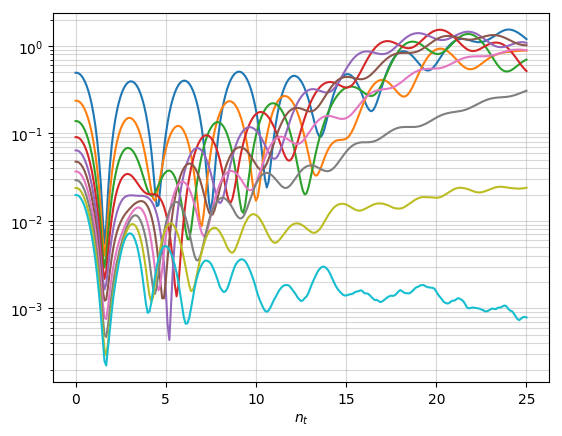

In [14]:
PyPlot.plot(t1, W[:,:])
PyPlot.xlabel(L"$n_t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)

IC = 0
Result = 0
GC.gc()

In [15]:
function find_maxima(w, n)
    maxima = []
    for i in (1+n):(length(w)-n)
        if issorted(w[i-n:i], lt=isless) && issorted(w[i:i+n], lt=isless, rev = true)
            append!(maxima, i)
        end
        end
    return maxima
end

function get_regression_αβ(t, W, n)
    nₚ = size(W, 2)
    α = zeros(nₚ)
    β = zeros(nₚ)
    for i in 1:nₚ
        m = find_maxima(W[:,i], n)
        #!! bump on tail
        m = m[2:5]
        β[i] = cov(t[m], log.(W[m,i]), corrected=false) / var(t[m], corrected=false) 
        α[i] = mean(log.(W[m,i])) - β[i]*mean(t[m])
    end
    return α, β
end 

get_regression_αβ (generic function with 1 method)

In [16]:
α, β = get_regression_αβ(t1, W, 5)
β

10-element Array{Float64,1}:
  0.013660509802017263
  0.09818995438449196 
  0.2056477016621461  
  0.24317526950626703 
  0.27420752694503625 
  0.26914169350396616 
  0.2253701551216558  
  0.1417121875287429  
  0.014543231212541514
 -0.13986065875093517 

In [17]:
Wₗᵢₙ = zero(W)
for i in 1:size(W,2)
    Wₗᵢₙ[:,i] .= exp.(α[i] .+ β[i] .* t1)
end

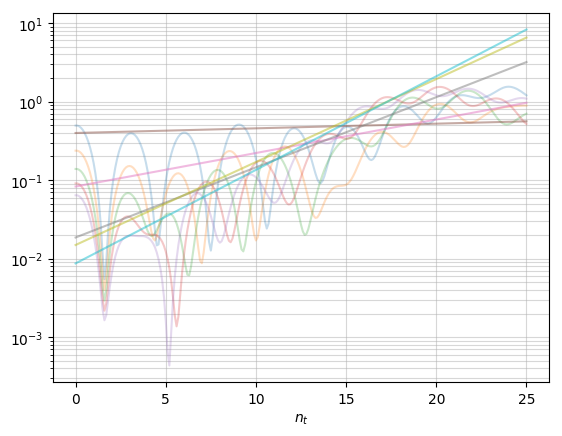

In [18]:
PyPlot.plot(t1, W[:,1:5], alpha=0.25)
PyPlot.plot(t1, Wₗᵢₙ[:,1:5], alpha=0.5)
#PyPlot.plot(t1[m], W[m,8], "o", color = "orange")
PyPlot.xlabel(L"$n_t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)

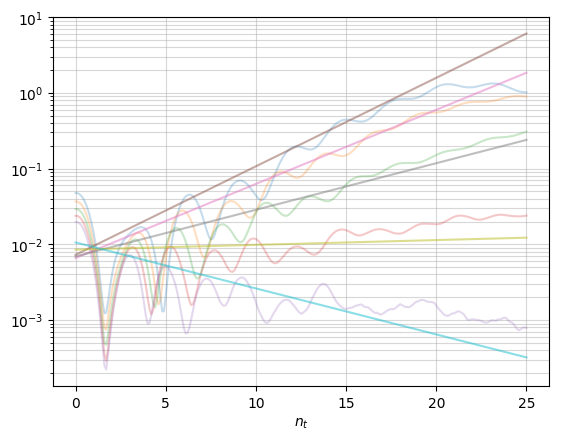

In [19]:
PyPlot.plot(t1, W[:,6:10], alpha=0.25)
PyPlot.plot(t1, Wₗᵢₙ[:,6:10], alpha=0.5)
#PyPlot.plot(t1[m], W[m,8], "o", color = "orange")
PyPlot.xlabel(L"$n_t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)